In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

## Short EDA

In [2]:
df = pd.read_csv('titanic.csv')
df.shape

(891, 12)

In [3]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [4]:
df.isna().sum() / df.shape[0]

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [5]:
# drop columns
df = df.drop(columns=['Name', 'Cabin', 'Ticket', 'Embarked', 'PassengerId'])

# fill nans
age_mean_male = df.loc[df['Sex']=='male', 'Age'].median()
age_mean_female = df.loc[df['Sex']=='female', 'Age'].median()
df.loc[(df['Sex']=='male')
      &(df['Age'].isna()), 'Age'] = age_mean_male
df.loc[(df['Sex']=='female')
      &(df['Age'].isna()), 'Age'] = age_mean_female

df.shape

(891, 7)

In [6]:
# dummies and decode dtypes
df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'SibSp', 'Parch'])
df = df.astype(np.float32)

In [7]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df[['Age', 'Fare']] = scaler.fit_transform(df[['Age', 'Fare']])

In [8]:
df.head()

,Survived,Age,Fare,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,SibSp_0,SibSp_1,...,SibSp_4,SibSp_5,SibSp_8,Parch_0,Parch_1,Parch_2,Parch_3,Parch_4,Parch_5,Parch_6
0,0.0,-0.571902,-0.502445,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.657785,0.786845,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,-0.264480,-0.488854,1.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.427219,0.420730,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.427219,-0.486337,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


## Pytorch Example

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [10]:
def accuracy_score(y_pred, y_true):
    return sum((y_pred.squeeze(-1) >= 0.5) == y_true) / len(y_true)

In [11]:
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 200

### Create Custom Dataset

In [12]:
# split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['Survived']), df['Survived'], test_size=0.2)

In [13]:
# create dataset
class CustomData(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __getitem__(self, index):
        return self.X[index], self.y[index]
        
    def __len__ (self):
        return len(self.X)
    
train_data = CustomData(torch.Tensor(X_train.values), torch.Tensor(y_train.values))
test_data = CustomData(torch.Tensor(X_test.values), torch.Tensor(y_test.values))

train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [14]:
def train_loop(early_stopping=False):
    early_stopping_count = 0
    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []

    for epoch in range(EPOCHS):
        # train loop
        epoch_loss = []
        epoch_acc = []
        model.train()
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()

            y_pred = model(X_batch)
            loss_train = loss(y_pred.squeeze(), y_batch)
            acc = accuracy_score(y_pred, y_batch)

            loss_train.backward()
            optimizer.step()

            epoch_loss.append(loss_train.item())
            epoch_acc.append(acc.item())

        # eval loop
        model.eval()
        with torch.no_grad():
            y_test_pred = model(test_loader.dataset.X)
            loss_test = loss(y_test_pred.squeeze(-1), test_loader.dataset.y)
            acc_test = accuracy_score(y_test_pred, test_loader.dataset.y)

        # update metrics
        train_loss_list.append(np.array(epoch_loss).mean())  
        train_acc_list.append(np.array(epoch_acc).mean())
        test_loss_list.append(loss_test)
        test_acc_list.append(acc_test)
        
        # calculations for early stopping
        if epoch <= 7:
            continue
        else:
            prev_losses = []
            weights = [1, 0.8, 0.6, 0.4, 0.2]
            for i in range(2, 7):
                prev_losses.append(test_loss_list[-i])
            current_loss = test_loss_list[-1]
            prev_loss = np.average(prev_losses, weights=weights)
            if current_loss >= prev_loss:
                early_stopping_count += 1
            else:
                early_stopping_count = 0
                
        if early_stopping and early_stopping_count >= 5:
            break

        print(f'Epoch {epoch+1}: | LossTrain: {round(np.array(epoch_loss).mean(), 3)}\
                LossTest {round(float(np.array(loss_test)), 3)} \
                | AccTrain: {np.array(epoch_acc).mean()} AccTest {round(float(acc_test), 3)}')
        
    return train_loss_list, train_acc_list, test_loss_list, test_acc_list

### Create First Model

In [15]:
# create simple model
class Model(nn.Module):
    def __init__(self, input_shape):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_shape, 8)
        self.layer2 = nn.Linear(8, 8)
        self.output = nn.Linear(8, 1)
        
        
        self.relu =nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()
        
        
    def forward(self, inputs):
        x = self.relu(self.layer1(inputs))
        x = self.relu(self.layer2(x))
        x = self.sigmoid(self.output(x))
        
        return x

In [16]:
model = Model(input_shape=train_data.X.shape[1])
loss = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [17]:
train_loss_list, train_acc_list, test_loss_list, test_acc_list = train_loop()

Epoch 9: | LossTrain: 0.554                LossTest 0.515                 | AccTrain: 0.7364130434782609 AccTest 0.782
Epoch 10: | LossTrain: 0.524                LossTest 0.487                 | AccTrain: 0.7690217391304348 AccTest 0.799
Epoch 11: | LossTrain: 0.5                LossTest 0.463                 | AccTrain: 0.7744565217391305 AccTest 0.81
Epoch 12: | LossTrain: 0.488                LossTest 0.447                 | AccTrain: 0.779891304347826 AccTest 0.81
Epoch 13: | LossTrain: 0.469                LossTest 0.438                 | AccTrain: 0.7934782608695652 AccTest 0.827
Epoch 14: | LossTrain: 0.463                LossTest 0.431                 | AccTrain: 0.8057065217391305 AccTest 0.821
Epoch 15: | LossTrain: 0.453                LossTest 0.427                 | AccTrain: 0.8043478260869565 AccTest 0.821
Epoch 16: | LossTrain: 0.443                LossTest 0.423                 | AccTrain: 0.8070652173913043 AccTest 0.821
Epoch 17: | LossTrain: 0.443                Lo

Epoch 78: | LossTrain: 0.409                LossTest 0.431                 | AccTrain: 0.8301630434782609 AccTest 0.827
Epoch 79: | LossTrain: 0.399                LossTest 0.432                 | AccTrain: 0.8355978260869565 AccTest 0.81
Epoch 80: | LossTrain: 0.393                LossTest 0.432                 | AccTrain: 0.8315217391304348 AccTest 0.81
Epoch 81: | LossTrain: 0.388                LossTest 0.432                 | AccTrain: 0.8342391304347826 AccTest 0.81
Epoch 82: | LossTrain: 0.401                LossTest 0.432                 | AccTrain: 0.8301630434782609 AccTest 0.827
Epoch 83: | LossTrain: 0.391                LossTest 0.433                 | AccTrain: 0.8315217391304348 AccTest 0.816
Epoch 84: | LossTrain: 0.391                LossTest 0.433                 | AccTrain: 0.8396739130434783 AccTest 0.816
Epoch 85: | LossTrain: 0.389                LossTest 0.433                 | AccTrain: 0.842391304347826 AccTest 0.821
Epoch 86: | LossTrain: 0.4                Lo

Epoch 147: | LossTrain: 0.373                LossTest 0.454                 | AccTrain: 0.842391304347826 AccTest 0.81
Epoch 148: | LossTrain: 0.374                LossTest 0.453                 | AccTrain: 0.8491847826086957 AccTest 0.81
Epoch 149: | LossTrain: 0.392                LossTest 0.453                 | AccTrain: 0.8369565217391305 AccTest 0.81
Epoch 150: | LossTrain: 0.396                LossTest 0.453                 | AccTrain: 0.8342391304347826 AccTest 0.81
Epoch 151: | LossTrain: 0.369                LossTest 0.454                 | AccTrain: 0.8505434782608695 AccTest 0.816
Epoch 152: | LossTrain: 0.38                LossTest 0.455                 | AccTrain: 0.8478260869565217 AccTest 0.81
Epoch 153: | LossTrain: 0.381                LossTest 0.455                 | AccTrain: 0.845108695652174 AccTest 0.816
Epoch 154: | LossTrain: 0.374                LossTest 0.456                 | AccTrain: 0.845108695652174 AccTest 0.81
Epoch 155: | LossTrain: 0.374             

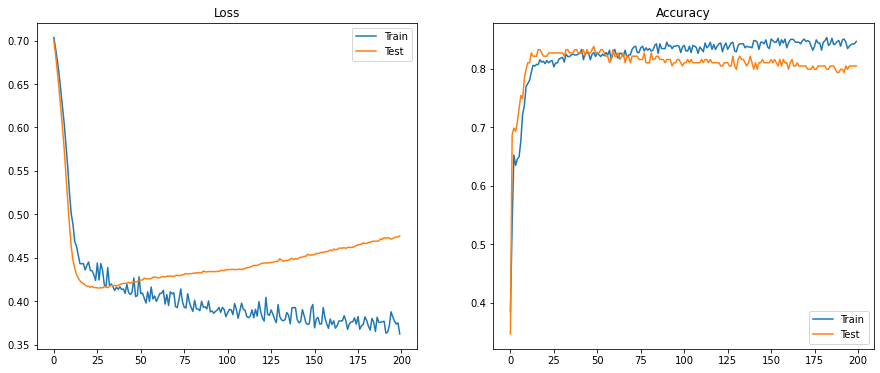

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(train_loss_list)
ax[0].plot(test_loss_list)
ax[0].set_title('Loss')
ax[1].plot(train_acc_list)
ax[1].plot(test_acc_list)
ax[1].set_title('Accuracy')
ax[0].legend(['Train', 'Test'])
ax[1].legend(['Train', 'Test'])
pass

### Model2

In [19]:
# create simple model
class Model2(nn.Module):
    def __init__(self, input_shape):
        super(Model2, self).__init__()
        self.layer1 = nn.Linear(input_shape, 8)
        self.dropout1 = nn.Dropout(0.5)
        self.batchnorm1 = nn.BatchNorm1d(8)
        self.layer2 = nn.Linear(8, 8)
        self.batchnorm2 = nn.BatchNorm1d(8)
        self.dropout2 = nn.Dropout(0.5)
        self.output = nn.Linear(8, 1)
        
        self.relu =nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
        
        
    def forward(self, inputs):
        x = self.layer1(inputs)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        x = self.layer2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.sigmoid(self.output(x))
        
        return x

In [20]:
model = Model2(input_shape=train_data.X.shape[1])
loss = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [21]:
train_loss_list, train_acc_list, test_loss_list, test_acc_list = train_loop()

Epoch 9: | LossTrain: 0.627                LossTest 0.592                 | AccTrain: 0.6521739130434783 AccTest 0.782
Epoch 10: | LossTrain: 0.601                LossTest 0.577                 | AccTrain: 0.6807065217391305 AccTest 0.793
Epoch 11: | LossTrain: 0.617                LossTest 0.56                 | AccTrain: 0.6453804347826086 AccTest 0.793
Epoch 12: | LossTrain: 0.587                LossTest 0.555                 | AccTrain: 0.688858695652174 AccTest 0.793
Epoch 13: | LossTrain: 0.59                LossTest 0.548                 | AccTrain: 0.6942934782608695 AccTest 0.793
Epoch 14: | LossTrain: 0.586                LossTest 0.549                 | AccTrain: 0.6766304347826086 AccTest 0.799
Epoch 15: | LossTrain: 0.587                LossTest 0.537                 | AccTrain: 0.686141304347826 AccTest 0.799
Epoch 16: | LossTrain: 0.57                LossTest 0.536                 | AccTrain: 0.7119565217391305 AccTest 0.804
Epoch 17: | LossTrain: 0.574                Lo

Epoch 79: | LossTrain: 0.488                LossTest 0.449                 | AccTrain: 0.7595108695652174 AccTest 0.832
Epoch 80: | LossTrain: 0.513                LossTest 0.445                 | AccTrain: 0.7581521739130435 AccTest 0.832
Epoch 81: | LossTrain: 0.497                LossTest 0.441                 | AccTrain: 0.7445652173913043 AccTest 0.832
Epoch 82: | LossTrain: 0.495                LossTest 0.44                 | AccTrain: 0.7690217391304348 AccTest 0.827
Epoch 83: | LossTrain: 0.498                LossTest 0.441                 | AccTrain: 0.7567934782608695 AccTest 0.827
Epoch 84: | LossTrain: 0.499                LossTest 0.439                 | AccTrain: 0.7282608695652174 AccTest 0.821
Epoch 85: | LossTrain: 0.511                LossTest 0.441                 | AccTrain: 0.7432065217391305 AccTest 0.827
Epoch 86: | LossTrain: 0.501                LossTest 0.445                 | AccTrain: 0.7567934782608695 AccTest 0.816
Epoch 87: | LossTrain: 0.485             

Epoch 149: | LossTrain: 0.501                LossTest 0.442                 | AccTrain: 0.7445652173913043 AccTest 0.838
Epoch 150: | LossTrain: 0.508                LossTest 0.439                 | AccTrain: 0.7445652173913043 AccTest 0.832
Epoch 151: | LossTrain: 0.515                LossTest 0.438                 | AccTrain: 0.7527173913043478 AccTest 0.838
Epoch 152: | LossTrain: 0.502                LossTest 0.442                 | AccTrain: 0.7391304347826086 AccTest 0.832
Epoch 153: | LossTrain: 0.483                LossTest 0.446                 | AccTrain: 0.7758152173913043 AccTest 0.832
Epoch 154: | LossTrain: 0.498                LossTest 0.45                 | AccTrain: 0.7622282608695652 AccTest 0.81
Epoch 155: | LossTrain: 0.485                LossTest 0.443                 | AccTrain: 0.7622282608695652 AccTest 0.827
Epoch 156: | LossTrain: 0.51                LossTest 0.445                 | AccTrain: 0.7418478260869565 AccTest 0.821
Epoch 157: | LossTrain: 0.517      

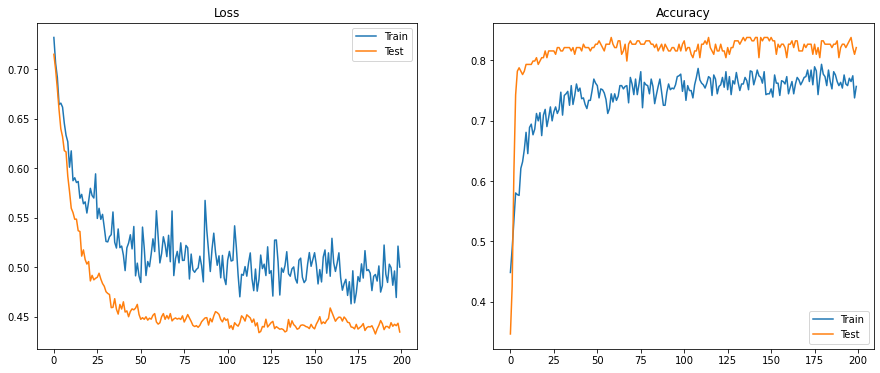

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(train_loss_list)
ax[0].plot(test_loss_list)
ax[0].set_title('Loss')
ax[1].plot(train_acc_list)
ax[1].plot(test_acc_list)
ax[1].set_title('Accuracy')
ax[0].legend(['Train', 'Test'])
ax[1].legend(['Train', 'Test'])
pass

### Model3

In [23]:
# create simple model
class Model3(nn.Module):
    def __init__(self, input_shape):
        super(Model3, self).__init__()
        self.output = nn.Linear(input_shape, 1)
        self.relu =nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        
    def forward(self, inputs):
        x = self.relu(self.output(inputs))
        x = self.sigmoid(x)
        
        return x

In [24]:
model = Model3(input_shape=train_data.X.shape[1])
loss = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [25]:
train_loss_list, train_acc_list, test_loss_list, test_acc_list = train_loop()

Epoch 9: | LossTrain: 0.665                LossTest 0.667                 | AccTrain: 0.39266304347826086 AccTest 0.346
Epoch 10: | LossTrain: 0.661                LossTest 0.665                 | AccTrain: 0.3967391304347826 AccTest 0.346
Epoch 11: | LossTrain: 0.658                LossTest 0.663                 | AccTrain: 0.4008152173913043 AccTest 0.346
Epoch 12: | LossTrain: 0.656                LossTest 0.661                 | AccTrain: 0.3967391304347826 AccTest 0.346
Epoch 13: | LossTrain: 0.654                LossTest 0.66                 | AccTrain: 0.39266304347826086 AccTest 0.346
Epoch 14: | LossTrain: 0.65                LossTest 0.658                 | AccTrain: 0.3967391304347826 AccTest 0.346
Epoch 15: | LossTrain: 0.651                LossTest 0.657                 | AccTrain: 0.39266304347826086 AccTest 0.346
Epoch 16: | LossTrain: 0.653                LossTest 0.656                 | AccTrain: 0.3845108695652174 AccTest 0.346
Epoch 17: | LossTrain: 0.651            

Epoch 79: | LossTrain: 0.614                LossTest 0.623                 | AccTrain: 0.3804347826086957 AccTest 0.346
Epoch 80: | LossTrain: 0.608                LossTest 0.623                 | AccTrain: 0.3967391304347826 AccTest 0.346
Epoch 81: | LossTrain: 0.606                LossTest 0.623                 | AccTrain: 0.39266304347826086 AccTest 0.346
Epoch 82: | LossTrain: 0.607                LossTest 0.623                 | AccTrain: 0.38858695652173914 AccTest 0.346
Epoch 83: | LossTrain: 0.605                LossTest 0.623                 | AccTrain: 0.4008152173913043 AccTest 0.346
Epoch 84: | LossTrain: 0.615                LossTest 0.623                 | AccTrain: 0.38858695652173914 AccTest 0.346
Epoch 85: | LossTrain: 0.607                LossTest 0.623                 | AccTrain: 0.3967391304347826 AccTest 0.346
Epoch 86: | LossTrain: 0.606                LossTest 0.622                 | AccTrain: 0.3967391304347826 AccTest 0.346
Epoch 87: | LossTrain: 0.604         

Epoch 154: | LossTrain: 0.598                LossTest 0.616                 | AccTrain: 0.38858695652173914 AccTest 0.346
Epoch 155: | LossTrain: 0.596                LossTest 0.616                 | AccTrain: 0.39266304347826086 AccTest 0.346
Epoch 156: | LossTrain: 0.598                LossTest 0.616                 | AccTrain: 0.38858695652173914 AccTest 0.346
Epoch 157: | LossTrain: 0.596                LossTest 0.616                 | AccTrain: 0.39266304347826086 AccTest 0.346
Epoch 158: | LossTrain: 0.596                LossTest 0.616                 | AccTrain: 0.38858695652173914 AccTest 0.346
Epoch 159: | LossTrain: 0.599                LossTest 0.616                 | AccTrain: 0.39266304347826086 AccTest 0.346
Epoch 160: | LossTrain: 0.593                LossTest 0.616                 | AccTrain: 0.3967391304347826 AccTest 0.346
Epoch 161: | LossTrain: 0.6                LossTest 0.616                 | AccTrain: 0.3845108695652174 AccTest 0.346
Epoch 162: | LossTrain: 0.59

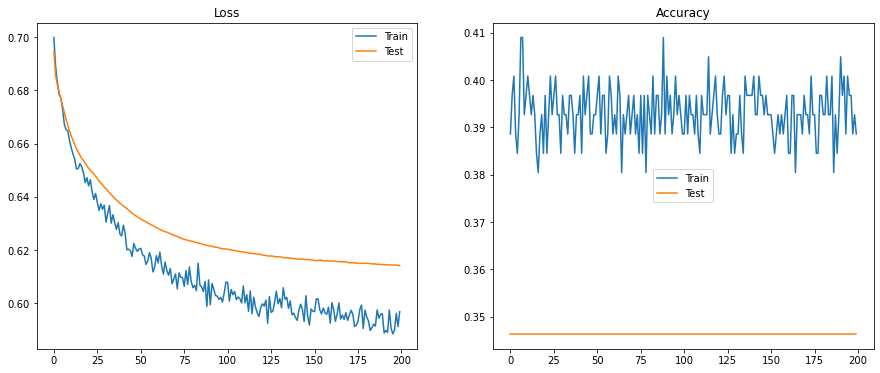

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(train_loss_list)
ax[0].plot(test_loss_list)
ax[0].set_title('Loss')
ax[1].plot(train_acc_list)
ax[1].plot(test_acc_list)
ax[1].set_title('Accuracy')
ax[0].legend(['Train', 'Test'])
ax[1].legend(['Train', 'Test'])
pass

### Early Stopping

In [27]:
model = Model(input_shape=train_data.X.shape[1])
loss = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [28]:
train_loss_list, train_acc_list, test_loss_list, test_acc_list = train_loop(early_stopping=True)

Epoch 9: | LossTrain: 0.527                LossTest 0.478                 | AccTrain: 0.7730978260869565 AccTest 0.799
Epoch 10: | LossTrain: 0.501                LossTest 0.465                 | AccTrain: 0.7894021739130435 AccTest 0.799
Epoch 11: | LossTrain: 0.492                LossTest 0.456                 | AccTrain: 0.7975543478260869 AccTest 0.81
Epoch 12: | LossTrain: 0.489                LossTest 0.449                 | AccTrain: 0.7948369565217391 AccTest 0.816
Epoch 13: | LossTrain: 0.478                LossTest 0.446                 | AccTrain: 0.7948369565217391 AccTest 0.816
Epoch 14: | LossTrain: 0.459                LossTest 0.441                 | AccTrain: 0.8084239130434783 AccTest 0.821
Epoch 15: | LossTrain: 0.46                LossTest 0.438                 | AccTrain: 0.8029891304347826 AccTest 0.821
Epoch 16: | LossTrain: 0.452                LossTest 0.434                 | AccTrain: 0.811141304347826 AccTest 0.821
Epoch 17: | LossTrain: 0.459                

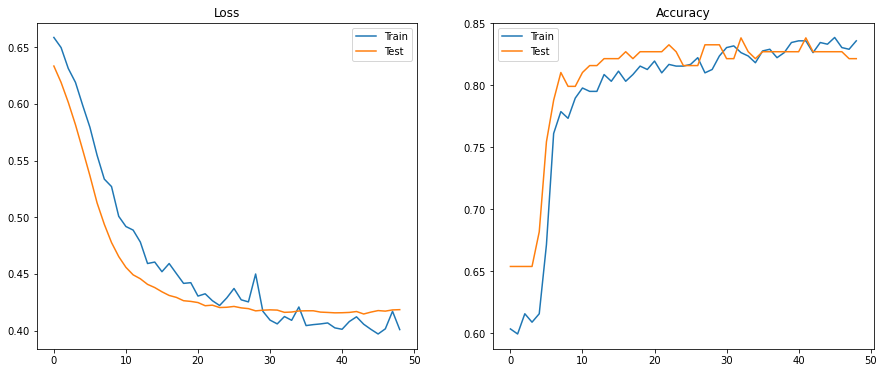

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))
ax[0].plot(train_loss_list)
ax[0].plot(test_loss_list)
ax[0].set_title('Loss')
ax[1].plot(train_acc_list)
ax[1].plot(test_acc_list)
ax[1].set_title('Accuracy')
ax[0].legend(['Train', 'Test'])
ax[1].legend(['Train', 'Test'])
pass